In [ ]:
import numpy as np
from functions import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS, TSNE
from sklearn.datasets import load_digits
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm
import umap
from sklearn.svm import SVC
import numpy as np
from sklearn.datasets import make_blobs

from sklearn.utils import check_random_state
import random

seed  = 5
random.seed(seed)
np.random.seed(seed)
rng = check_random_state(seed)


def alpha_quick(pts):
    #print( cdist([pts[-1]], pts[:-1]).shape)
    # this works for a configuration generates from our random cluster alpha configuration with one cluster
    return np.min(cdist([pts[-1]], pts[:-1])) / diam(pts[:-1])

# calculates the alpha-statistic of a point with respect to the other points
def alpha_(pts, ix):
    X = pts
    y = np.ones(len(pts))
    y[ix] = -1

    clf = SVC(kernel="linear", C=1e12)
    clf.fit(X,y)
    if np.all(clf.predict(X) == y):
        return 2 * (1.0 / np.linalg.norm(clf.coef_))/diam(pts[np.where(y==1)])
    else:
        return 0

def alpha(pts):
    max_margin = 0
    for i in range(len(pts)):
        x0 = np.asarray(pts[i]).reshape(1, -1)
        S = np.vstack([pts[:i], pts[i+1:]] )
        max_margin = min([max_margin, alpha_(x0, S)] ) 
    return max_margin

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

# k clusters with an alpha outlier
# for a single outlier, alpha is exact
# for more than one outlier, alpha is a lower bound
def create_cluster_outlier_config(alpha, n, k, d, num_outliers, std=1.0, rng=np.random.default_rng()):

    X, y = make_blobs(n_samples=n, centers=k, n_features=d, random_state=0, cluster_std=std)
    mu = X.mean(axis=0)

    for i in range(num_outliers):
        # pick random direction
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)

        # project points relative to mu
        proj = (X - mu) @ v
        if i == 1:
            # use point with highest projection, for most accurate possible alpha
            j = np.argmax(proj[:n])
            v = (X[j] - mu) 
            v_unit = v / np.linalg.norm(v)

            outlier = mu + (np.linalg.norm(v) + alpha*diam(X))* v_unit 
        else:
            outlier = mu + (proj.max() + alpha*diam(X))*v 

        X = np.concatenate((X, np.array( [outlier])), axis=0)

    return X


computed alpha (using SVM)	 1.0220021080621553
true alpha 			 1.0


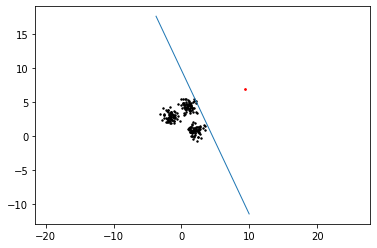

In [ ]:
## 2d plot of an alpha-outlier configuration!
ALPHA = 1.0

X= create_cluster_outlier_config(alpha=ALPHA, n=200, k=3, d=2, num_outliers=1, std=0.6)
mu = np.mean(X[:-1], axis=0)
v = X[-1] - mu
v /= np.linalg.norm(v)
c = ((X[:-1] - mu) @ v).max()

barrier = mu + v*c

ax = plt.gca()
plt.scatter(X[:-1,0], X[:-1,1],c='black', s=2)
plt.scatter(X[-1,0], X[-1,1],c='red', s=3)
plt.axis('equal')

xlim = ax.get_xlim()
x_vals = np.linspace(xlim[0], xlim[1], 2)
y_vals = (-v[0]/v[1]) * (x_vals - barrier[0]) + barrier[1]
plt.plot(x_vals, y_vals, linewidth = 1)

print('computed alpha (using SVM)\t', alpha_quick(X))
print('true alpha \t\t\t', ALPHA)

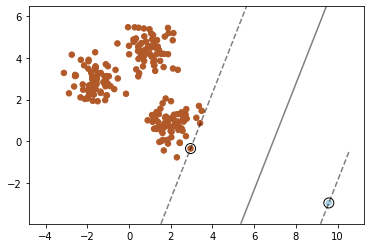

In [ ]:

X= create_cluster_outlier_config(alpha=ALPHA, n=200, k=3, d=2, num_outliers=1, std=0.6)

y = np.ones(len(X))
y[-1] = -1


<ipython-input-554-28b78cac423f>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:-1, 0], X[:-1, 1], c='black', s=60, cmap=plt.cm.Paired)
<ipython-input-554-28b78cac423f>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[-1, 0], X[-1, 1], c='red', s=60, cmap=plt.cm.Paired)


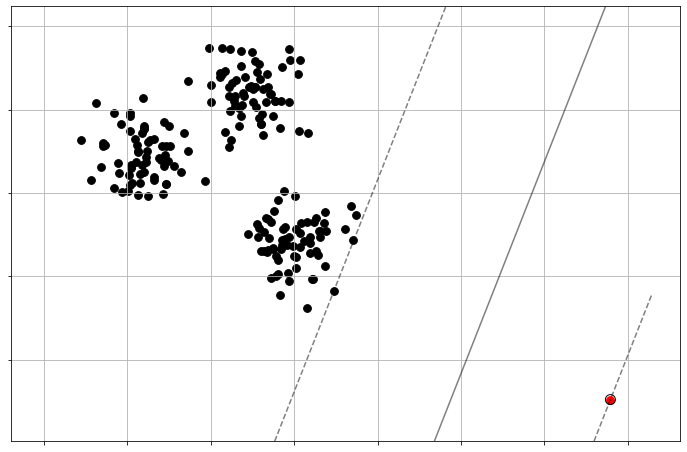

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel="linear", C=1e12)
clf.fit(X, y)


plt.scatter(X[:-1, 0], X[:-1, 1], c='black', s=60, cmap=plt.cm.Paired)
plt.scatter(X[-1, 0], X[-1, 1], c='red', s=60, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
fig = ax.figure
fig.set_size_inches(12, 8)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0][0],
    clf.support_vectors_[:, 1][0],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.axis('equal')
plt.grid('on')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('visuals/outliers/illustrative_plot_.png')

plt.show()

5 clusters, 3 (alpha >= 0.2)-outliers


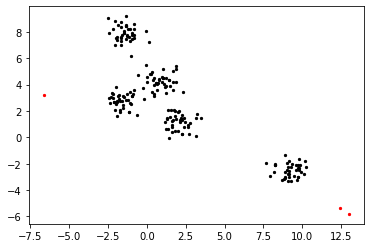

In [ ]:
n_outliers  = 3
X= create_cluster_outlier_config(alpha=0.2, n=200, k=5, d=2, num_outliers=n_outliers, std=0.6)
plt.scatter(X[:-n_outliers,0],X[:-n_outliers,1], c='black', s=5)
plt.scatter(X[-n_outliers:,0],X[-n_outliers:,1], c='red', s=5)
print('5 clusters, 3 (alpha >= 0.2)-outliers')

In [ ]:
from tqdm import tqdm

plots = []
num_outliers = [1,5,10, 50, 100]
num_clusters = [1,2,5]

for i in tqdm(range(len(num_outliers))):
    plots.append([])
    for j in range(len(num_clusters)):
        X= create_cluster_outlier_config(alpha=10, n=500, k=num_clusters[j], d=100, num_outliers=num_outliers[i], std=0.6)
        X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)
        plots[i].append(X_tsne)

1 1
1 2
1 5
5 1
5 2
5 5
10 1
10 2
10 5


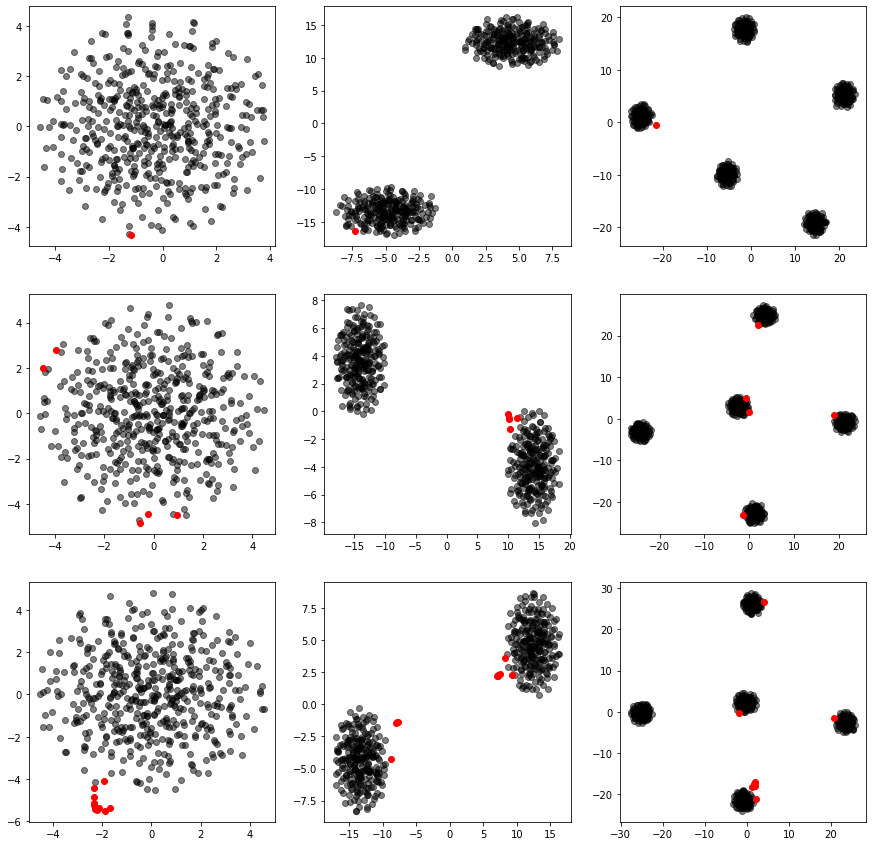

In [ ]:
fig, axs=plt.subplots(5,3, figsize=(15,15))

for i in range(len(num_outliers)):
    for j in range(len(num_clusters)):
        m = num_outliers[i]
        axs[i,j].scatter(plots[i][j][:-m,0], plots[i][j][:-m,1], alpha=0.5 , c='black')
        axs[i,j].scatter(plots[i][j][-m:,0], plots[i][j][-m:,1],  c='r')


In [ ]:
alphas = np.linspace(0.1, 5, 100)

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42, method='exact', perplexity=30)


pca_alphas = []
tsne_alphas = []
for a in tqdm(alphas):
    X = create_cluster_outlier_config(alpha=a, n=100, k=1, d=20, num_outliers=1, std=0.6)

    X_pca = pca.fit_transform(X)
    X_tsne = tsne.fit_transform(X)
    pca_alphas.append( alpha_quick(X_pca ) )
    tsne_alphas.append( alpha_quick(X_tsne) )


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


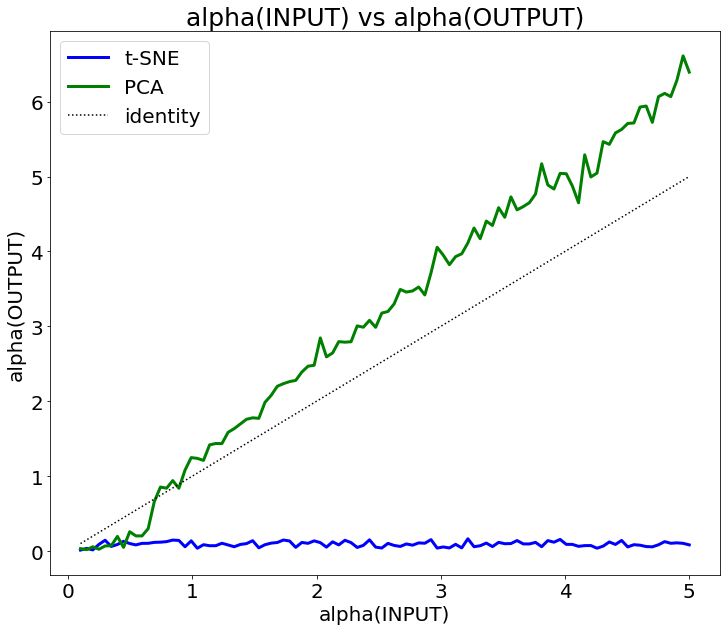

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))


ax.plot(alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
ax.plot(alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
ax.plot(alphas, alphas,  linestyle=':', color='black', label='identity')

ax.tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
ax.set_xlabel("alpha(INPUT)", fontsize=20)
ax.set_ylabel("alpha(OUTPUT)", fontsize=20)
ax.set_title("alpha(INPUT) vs alpha(OUTPUT)",fontsize=25)
ax.legend(prop={'size': 20})

plt.savefig('visuals/outlier_new/alpha_IN_OUT.png')

In [ ]:
alphas = np.linspace(0.1, 50, 50)

tsne = TSNE(n_components=2, random_state=42, method='exact', perplexity=30)


tsne_alphas_ = []
for a in tqdm(alphas):
    X = create_cluster_outlier_config(alpha=a, n=100, k=1, d=20, num_outliers=1, std=0.6)
    X_tsne = tsne.fit_transform(X)
    tsne_alphas_.append( alpha_quick(X_tsne) )

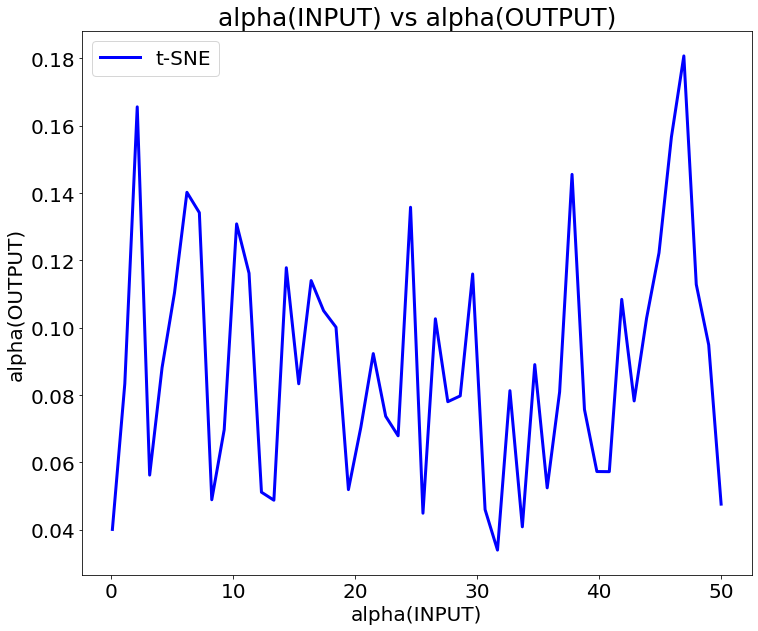

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(alphas, tsne_alphas_, color='blue', linewidth = 3, label='t-SNE')

ax.tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
ax.set_xlabel("alpha(INPUT)", fontsize=20)
ax.set_ylabel("alpha(OUTPUT)", fontsize=20)
ax.set_title("alpha(INPUT) vs alpha(OUTPUT)",fontsize=25)
ax.legend(prop={'size': 20})

plt.savefig('visuals/outlier_new/alpha_IN_OUT_justTSNE.png')

In [ ]:
X = create_cluster_outlier_config(alpha=1, n=500, k=1, d=20, num_outliers=1, std=0.6)

X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

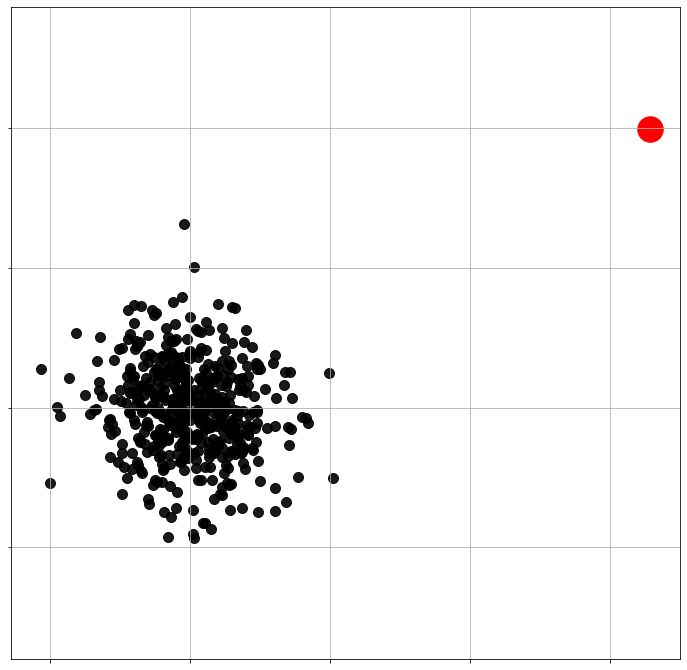

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_pca[:-1, 0], X_pca[:-1, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red')
plt.savefig('visuals/outlier_new/PCA_1outlier.png')

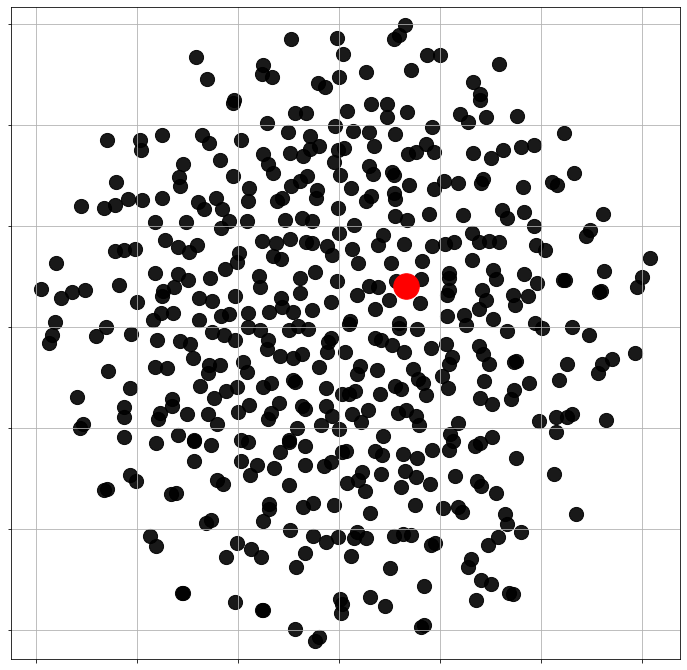

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_tsne[:-1, 0], X_tsne[:-1, 1], s=200, alpha=0.9, c='black')
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red', marker='o')
plt.savefig('visuals/outlier_new/TSNE_1outlier.png')

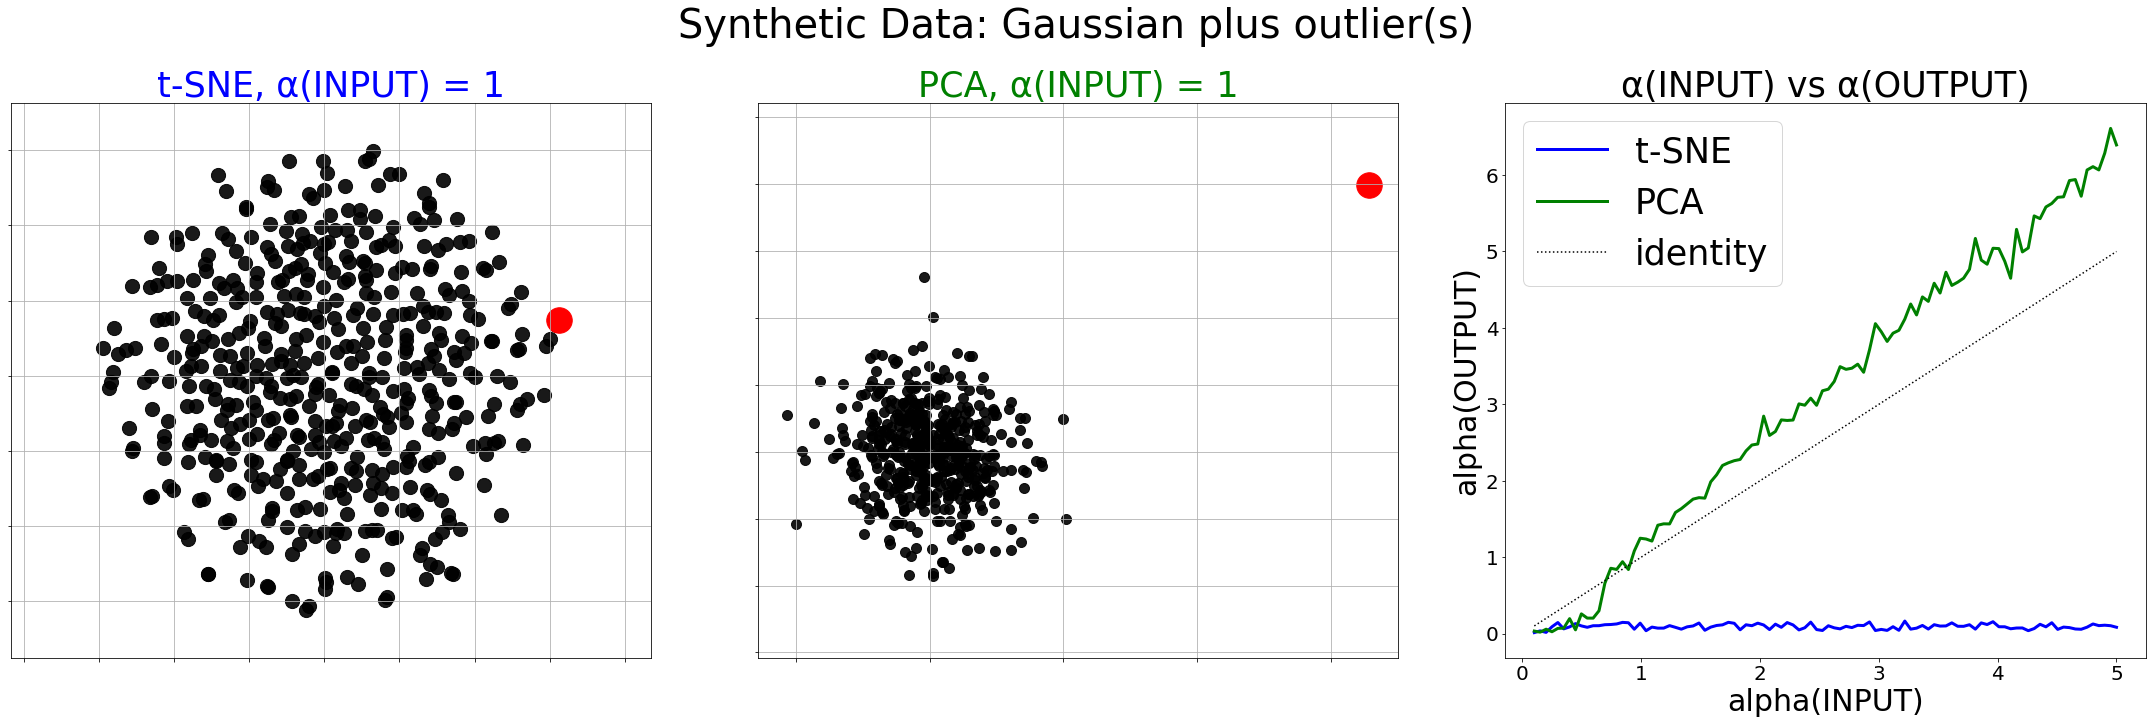

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
import matplotlib.gridspec as gridspec

#gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 0.3, 1])  
#ax1 = fig.add_subplot(gs[0])

for i in range(2):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])


axs[0].set_title('t-SNE, α(INPUT) = 1', fontsize=35, color='blue')
axs[0].scatter(X_tsne[:-1, 0], X_tsne[:-1, 1], s=200, alpha=0.9, c='black')
axs[0].scatter(X_tsne[-1, 0], X_tsne[-1, 1], s=650, alpha=1, c='red', marker='o')

axs[1].set_title('PCA, α(INPUT) = 1', fontsize=35, color='green')
axs[1].scatter(X_pca[:-1, 0], X_pca[:-1, 1], s=100, alpha=0.9, c='black')
axs[1].scatter(X_pca[-1, 0], X_pca[-1, 1], s=650, alpha=1, c='red')

axs[2].plot(alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
axs[2].plot(alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
axs[2].plot(alphas, alphas,  linestyle=':', color='black', label='identity')
axs[2].tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
axs[2].set_xlabel("alpha(INPUT)", fontsize=30)
axs[2].set_ylabel("alpha(OUTPUT)", fontsize=30)
axs[2].set_title("α(INPUT) vs α(OUTPUT)",fontsize=35)
axs[2].legend(prop={'size': 35})

# get position of the 3rd subplot
pos = axs[2].get_position()
# shift it to the right (x0, y0, width, height)
axs[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])
plt.suptitle('Synthetic Data: Gaussian plus outlier(s)',y=1.001, fontsize=40)

plt.tight_layout()
plt.savefig('visuals/outlier_new/OUTLIER_MAIN1.png',  bbox_inches='tight')


In [ ]:
m = 3

X = create_cluster_outlier_config(alpha=1, n=200, k=3, d=20, num_outliers=m, std=0.6)


X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

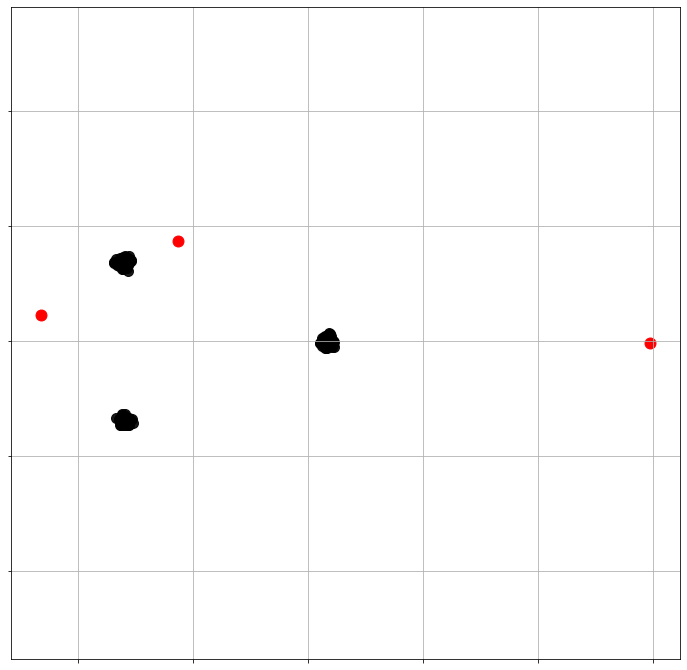

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_pca[:-m, 0], X_pca[:-m, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_pca[-m:, 0], X_pca[-m:, 1], s=120, alpha=1, c='red')
plt.savefig(f'visuals/outlier_new/PCA_{m}outlier.png')

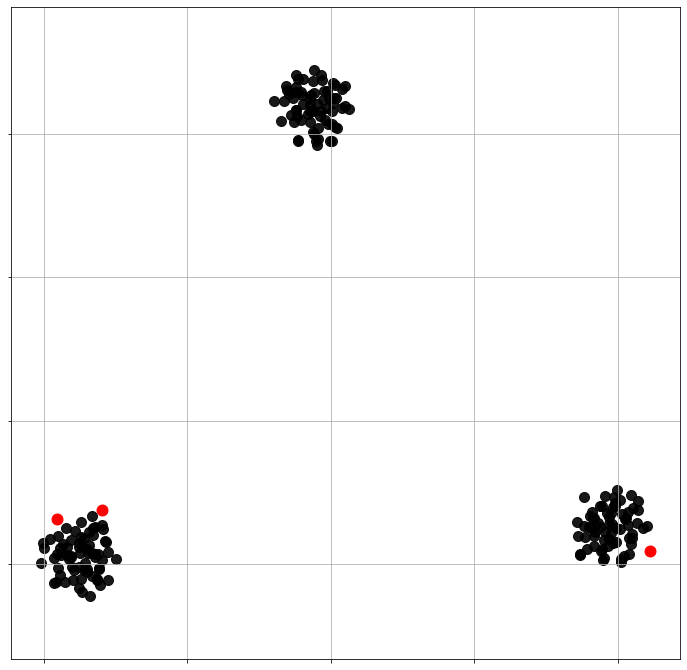

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.scatter(X_tsne[:-m, 0], X_tsne[:-m, 1], s=100, alpha=0.9, c='black')
plt.scatter(X_tsne[-m:, 0], X_tsne[-m:, 1], s=120, alpha=1, c='red')
plt.savefig(f'visuals/outlier_new/TSNE_{m}outlier.png')

In [ ]:
def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

In [ ]:
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)
X1 = np.concatenate((X, np.array( [  np.mean(X, axis=0)  ])), axis=0)

In [ ]:
X2 = X.copy()
m = 100
for i in range(m):
    outlier = np.random.normal(size=(1,X2.shape[1]))
    X2 = np.concatenate( (X2,  outlier ) , axis=0)

In [ ]:
X_tsne0 = tsne.fit_transform(X)
X_tsne1 = tsne.fit_transform(X1)
X_tsne2 = tsne.fit_transform(X2)

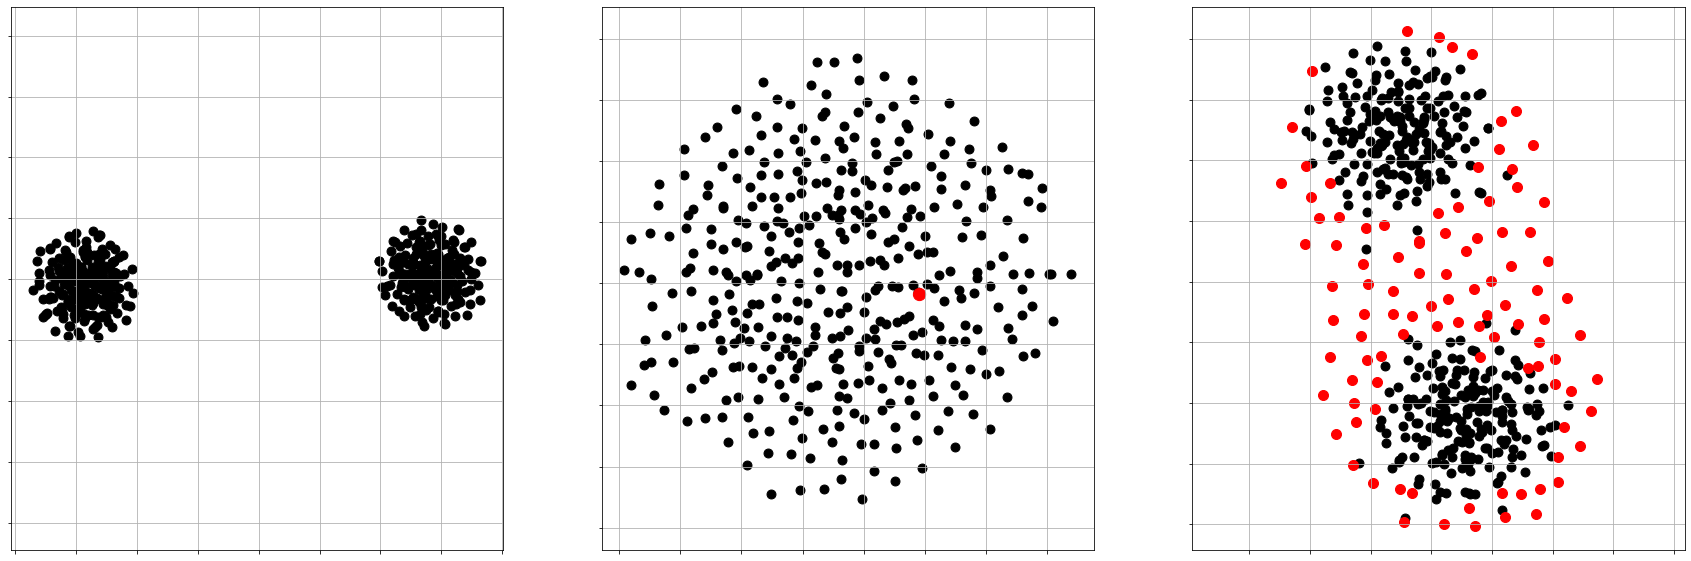

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
n = len(X)

for i in range(3):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1], s=150, color='red')
axs[2].scatter(X_tsne2[:-m,0],X_tsne2[:-m,1], s=80, color='black')
axs[2].scatter(X_tsne2[-m:,0],X_tsne2[-m:,1], s=100, color='red')

plt.savefig('visuals/outlier_new/internal_vs_external_outlier.png')

In [ ]:
X_pca0 = pca.fit_transform(X)
X_pca1 = pca.fit_transform(X1)

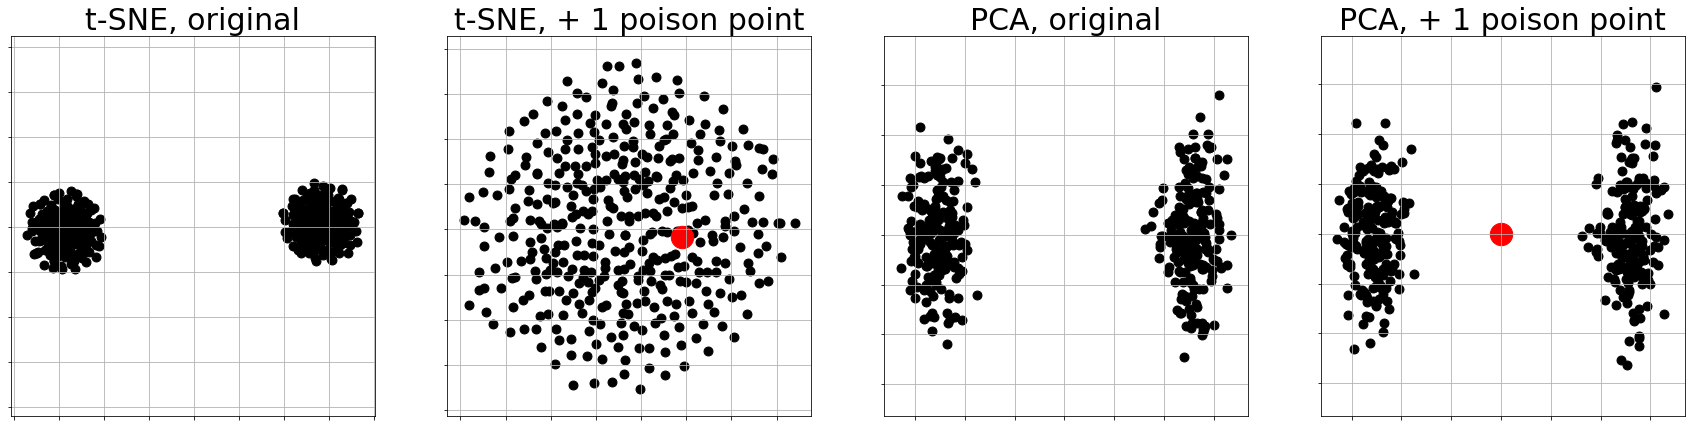

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(30,7))
n = len(X)

for i in range(4):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[0].set_title('t-SNE, original', fontsize=30)

axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1],  s=500, color='red')
axs[1].set_title('t-SNE, + 1 poison point', fontsize=30)


axs[2].scatter(X_pca0[:,0],X_pca0[:,1],  s=80,color='black')
axs[2].set_title('PCA, original', fontsize=30)

axs[3].scatter(X_pca1[:-1,0],X_pca1[:-1,1], s=80, color='black')
axs[3].scatter(X_pca1[-1,0],X_pca1[-1,1],  s=500, color='red')
axs[3].set_title('PCA, + 1 poison point', fontsize=30)


plt.savefig('visuals/outlier_new/one_pt_perturb.png', bbox_inches='tight' )

In [ ]:
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)


injected_points = [1, 10, 100, 500, 1000]
TSNE_plots = []
PCA_plots = []



for i in tqdm(injected_points):
    X__ = np.concatenate( (X,  np.mean(X,axis=0) + 0.2 * np.random.normal(size=( i ,X.shape[1]))  ) , axis=0)
    TSNE_plots.append( tsne.fit_transform(X__)  )
    PCA_plots.append( pca.fit_transform(X__)  )


100%|██████████| 5/5 [00:52<00:00, 10.60s/it]


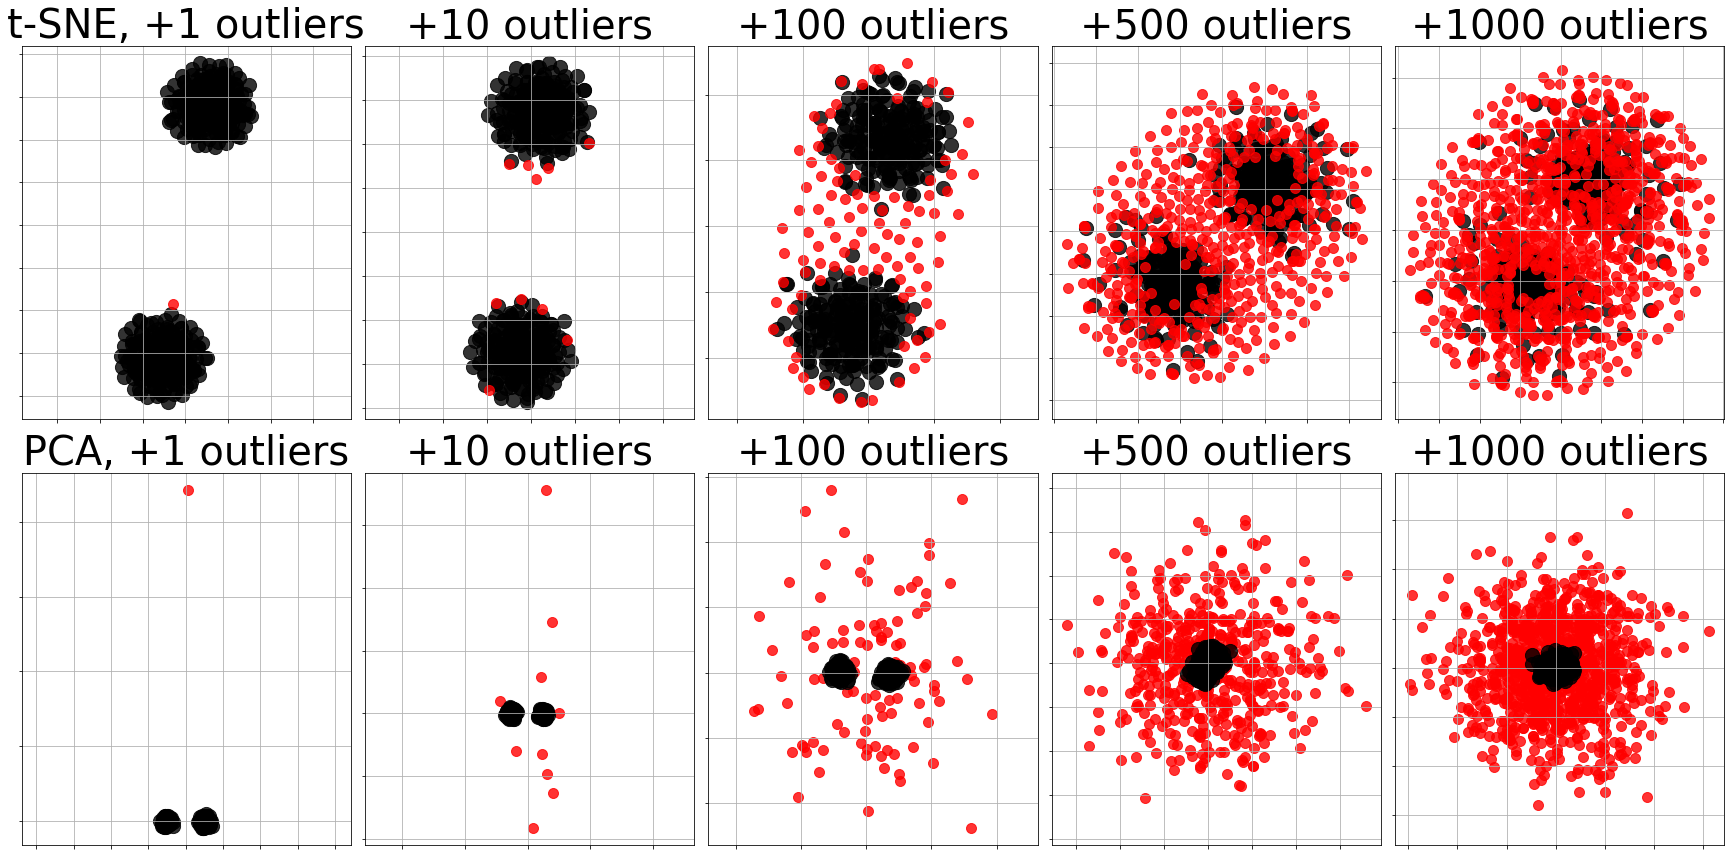

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(24,12))

#axs[0,0].set_ylabel('t-SNE', fontsize=50, rotation='horizontal')
#axs[1,0].set_ylabel('PCA', fontsize=50, rotation='horizontal')

for i in range(5):
    axs[0,i].grid('on')
    axs[0,i].axis('equal')
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    axs[1,i].grid('on')
    axs[1,i].axis('equal')
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])

    m = injected_points[i]
    if i==0:
        axs[0, i].set_title(f't-SNE, +{m} outliers', fontsize=40)
        axs[1, i].set_title(f'PCA, +{m} outliers', fontsize=40)
    else:
        axs[0, i].set_title(f'+{m} outliers', fontsize=40)
        axs[1, i].set_title(f'+{m} outliers', fontsize=40)
    axs[0,i].scatter(  TSNE_plots[i][:-m,0] ,  TSNE_plots[i][:-m,1], s=200,color='black', alpha=0.8)
    axs[0,i].scatter(  TSNE_plots[i][-m:,0] ,  TSNE_plots[i][-m:,1], s=100, color='red', alpha=0.8)

    axs[1,i].scatter(  PCA_plots[i][-m:,0] ,  PCA_plots[i][-m:,1], s=100, color='red', alpha=0.8)
    axs[1,i].scatter(  PCA_plots[i][:-m,0] ,  PCA_plots[i][:-m,1], s=200, color='black', alpha=0.8)
plt.tight_layout()
plt.savefig('visuals/outlier_new/outlier_infusion.png',  bbox_inches='tight')

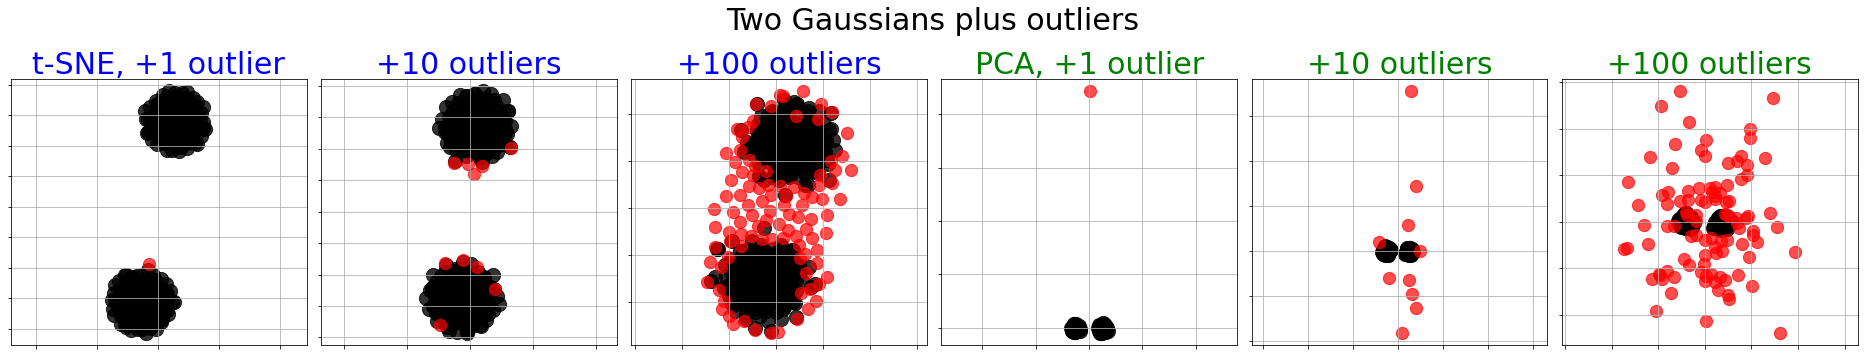

In [ ]:
fig, axs = plt.subplots(1,6, figsize=(26,5))

#axs[0,0].set_ylabel('t-SNE', fontsize=50, rotation='horizontal')
#axs[1,0].set_ylabel('PCA', fontsize=50, rotation='horizontal')

for i in range(6):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])



for i in range(3):
    m = injected_points[i]
    if i==0:
        axs[i].set_title(f't-SNE, +{m} outlier', fontsize=30, color='blue')
        axs[3+i].set_title(f'PCA, +{m} outlier', fontsize=30, color='green')
    else:
        axs[i].set_title(f'+{m} outliers', fontsize=30, color='blue')
        axs[3+i].set_title(f'+{m} outliers', fontsize=30, color='green')
    axs[i].scatter(  TSNE_plots[i][:-m,0] ,  TSNE_plots[i][:-m,1], s=200,color='black', alpha=0.8)
    axs[i].scatter(  TSNE_plots[i][-m:,0] ,  TSNE_plots[i][-m:,1], s=150, color='red', alpha=0.7)

    axs[3+i].scatter(  PCA_plots[i][:-m,0] ,  PCA_plots[i][:-m,1], s=200, color='black', alpha=0.8)
    axs[3+i].scatter(  PCA_plots[i][-m:,0] ,  PCA_plots[i][-m:,1], s=150, color='red', alpha=0.7)

plt.suptitle('Two Gaussians plus outliers', fontsize=30)
plt.tight_layout()

plt.savefig('visuals/outlier_new/outlier_infusion.png',  bbox_inches='tight')

 80%|████████  | 4/5 [00:07<00:02,  2.01s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


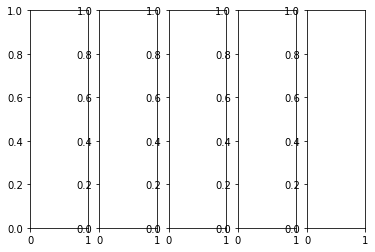

In [ ]:
outliers = [1,10,20,50]

tsnes = []

for i in tqdm(range(len(outliers))):
    o = outliers[i]
    X = create_cluster_outlier_config(alpha=1, n=200, k=1, d=3, num_outliers=o, std=0.6)
    X_tsne = tsne.fit_transform(X)
    tsnes.append(X_tsne)
    

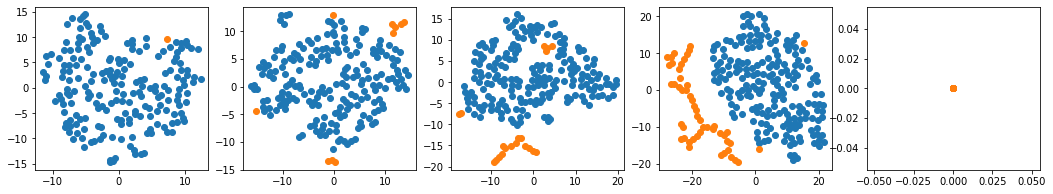

In [ ]:
fig, axs = plt.subplots(1,len(outliers), figsize=(18,3))

for i in range(len(tsnes)):
    X_tsne=tsnes[i]
    o = outliers[i]
    axs[i].set_title(f'{o} outliers (alpha=1)')
    axs[i].scatter(X_tsne[:-o,0], X_tsne[:-o,1])
    axs[i].scatter(X_tsne[-o:,0], X_tsne[-o:,1])

fig.suptitle('outliers become a distinct cluster when input dimension is low (d=2)')

(210, 100)


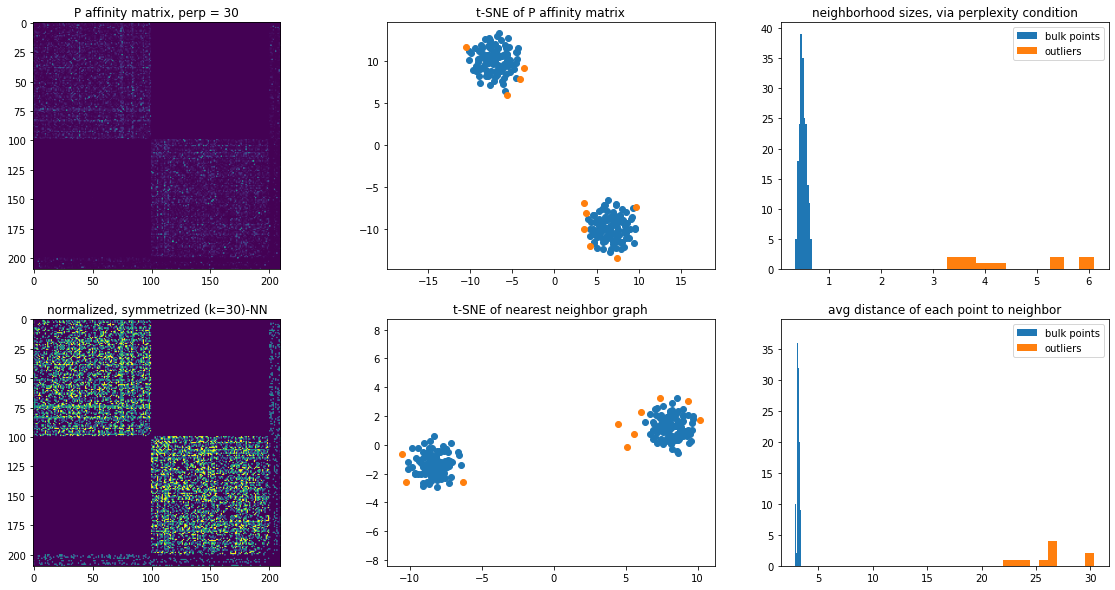

In [ ]:
from functions import x2p
import numpy as np
from functions import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS, TSNE
from sklearn.datasets import load_digits
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm
import umap
from sklearn.neighbors import kneighbors_graph


far = 2
dim = 100
num_outliers = 10
n = 200
n_neighbors = 40

X = create_cluster_outlier_config(alpha=1, n=200, k=3, d=2, num_outliers=1, std=0.6)
partition = [ list(range(n)), list(range(n, n + num_outliers))  ]


P, sigma = x2p(X, perplexity=n_neighbors)
#Y, loss_curve, radius_curve, Z_curve = tsne_(P)
Y = TSNE(n_components=2, random_state=42, method='exact', perplexity=30).fit_transform(X)


A = kneighbors_graph(X, n_neighbors=30, mode='connectivity', include_self=False)
A = A.toarray()
A /= np.sum(A, axis=1)
A += A.T
A /= np.sum(A)
Y_A, loss_curve, radius_curve, Z_curve = tsne_(A)

nbhd_sizes_A = np.sum(kneighbors_graph(X, n_neighbors=n_neighbors, metric='euclidean',mode='distance', include_self=False).toarray(), axis=1) / 30

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].imshow(P)
axs[0,0].set_title('P affinity matrix, perp = 30')
axs[0,1].scatter(Y[partition[0],0],Y[partition[0],1], label='sigma of bulk')
axs[0,1].scatter(Y[partition[1],0],Y[partition[1],1], label='sigma of outliers')
axs[0,1].axis('equal')
axs[0,1].set_title('t-SNE of P affinity matrix')
axs[0,2].hist(sigma[partition[0]]**2, label='bulk points')
axs[0,2].hist(sigma[partition[1]]**2, label='outliers')
axs[0,2].legend()
axs[0,2].set_title('neighborhood sizes, via perplexity condition')


axs[1,0].imshow(A)
axs[1,0].set_title('normalized, symmetrized (k=30)-NN')
axs[1,1].scatter(Y_A[partition[0],0],Y_A[partition[0],1], label='sigma of bulk')
axs[1,1].scatter(Y_A[partition[1],0],Y_A[partition[1],1], label='sigma of outliers')
axs[1,1].axis('equal')
axs[1,1].set_title('t-SNE of nearest neighbor graph')
axs[1,2].hist(nbhd_sizes_A[partition[0]], label='bulk points')
axs[1,2].hist(nbhd_sizes_A[partition[1]], label='outliers')
axs[1,2].legend()
axs[1,2].set_title('avg distance of each point to neighbor')

fig.suptitle('comaprison of t-sne affinity matrix and nearest-neighbor affinity')
plt.savefig('visuals/outliers/comparison_with_knn')
#plt.hist()